In [1]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
from datetime import date
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
def GetPrices(stocks,period=date(2015,1,1)):
    PricesDaily = DataReader(stocks,"yahoo",period)
    PricesDaily = PricesDaily['Adj Close']
    return PricesDaily

In [3]:
stocks = ['SPY','IVV','AGG','BND','VNQ','SCHH']

In [4]:
stock_dict = {'SPY':'SPY, SPDR S&P 500 ETF Trust',
              'IVV':'IVV, iShares Core S&P 500 ETF',
             'AGG':'AGG, iShares Core U.S. Aggregate Bond ETF',
              'BND':'BND, Vanguard Total Bond Market ETF',
              'VNQ':'VNQ, Vanguard Real Estate ETF',
              'SCHH':'SCHH, Schwab U.S. REIT ETF'}

In [5]:
Prices = GetPrices(stocks=stocks, period=date(2017,1,1))

In [6]:
Prices.isna().sum()

Symbols
SPY     0
IVV     0
AGG     0
BND     0
VNQ     0
SCHH    0
dtype: int64

In [9]:
Prices.columns = Prices.columns.map(stock_dict) ##add fund name

In [24]:
Prices.columns

Index(['SPY, SPDR S&P 500 ETF Trust', 'IVV, iShares Core S&P 500 ETF',
       'AGG, iShares Core U.S. Aggregate Bond ETF',
       'BND, Vanguard Total Bond Market ETF', 'VNQ, Vanguard Real Estate ETF',
       'SCHH, Schwab U.S. REIT ETF'],
      dtype='object', name='Symbols')

In [11]:
Returns = np.log(Prices/Prices.shift(1))

In [12]:
Returns.dropna(inplace=True)

In [13]:
def annualize_ret(r, periods):
    compound_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compound_growth**(periods/n_periods)-1

def annualize_vol(r, periods):
    return r.std()*(periods**0.5)

In [14]:
def portfolio_return(weights, returns):
    return weights.T @ returns

def portfolio_vol(weights, covmat):
    vol = (weights.T @ covmat @ weights)**0.5
    return vol

## How did the ETFs perform over time

<AxesSubplot:xlabel='Date'>

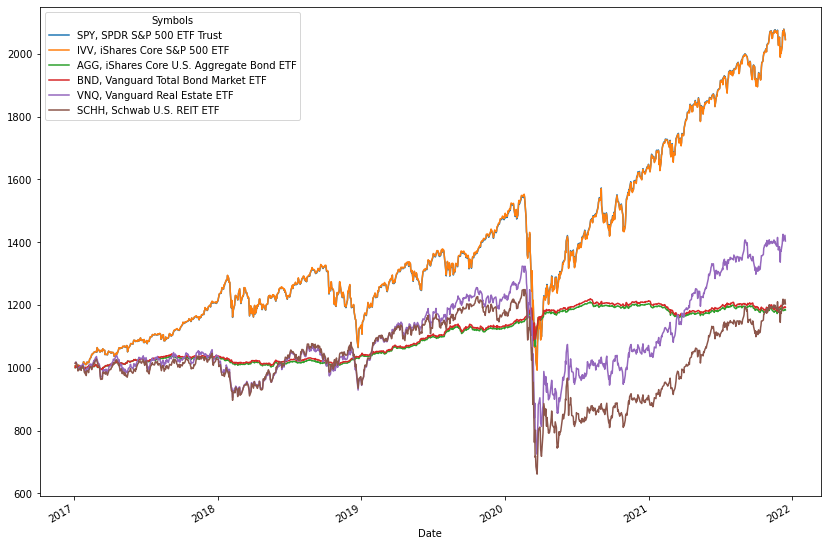

In [15]:
wealth_index = 1000*(1+Returns).cumprod()
wealth_index.plot(figsize=(14,10))

In [16]:
annual_ret = annualize_ret(Returns,periods=252)

In [17]:
covariance = Returns.cov()

In [18]:
Monthly_return_1 = Returns.resample('M').mean()

<AxesSubplot:xlabel='Date'>

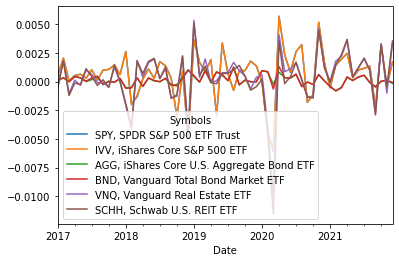

In [19]:
Monthly_return_1.plot() ##month returns

### Portfolio return and vol of an equally weighted portfolio

In [20]:
weights = np.repeat(1/covariance.shape[0], covariance.shape[0])

In [21]:
portfolio_return(weights, annual_ret)*100

8.197851812014985

In [22]:
portfolio_vol(weights, covariance*252)*100

13.514999427518084

# 2 Asset Frontier

In [25]:
subset = ['SPY, SPDR S&P 500 ETF Trust', 'AGG, iShares Core U.S. Aggregate Bond ETF']
rets_1 = annual_ret[subset]
cov_1 = covariance.loc[subset,subset]*252

In [26]:
def plot_2assetfrontier(n_points, rets, cov):
    weights = [np.array([w, 1-w]) for w in np.linspace(0,1,n_points)]
    rets = [portfolio_return(w, rets) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({'Rets': rets,
                      'Vols': vols})
    return ef.plot.scatter(x='Vols', y='Rets')

<AxesSubplot:xlabel='Vols', ylabel='Rets'>

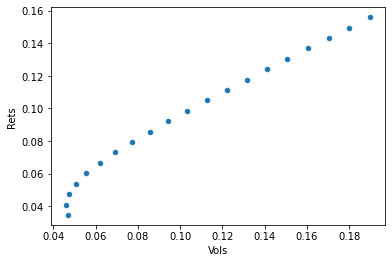

In [27]:
plot_2assetfrontier(20,rets_1,cov_1)

<AxesSubplot:xlabel='Vols', ylabel='Rets'>

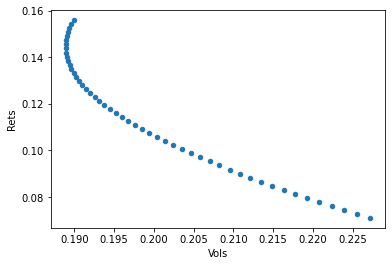

In [28]:
subset = ['SPY, SPDR S&P 500 ETF Trust','VNQ, Vanguard Real Estate ETF'] ##efficient frontier for two etf's
rets_2 = annual_ret[subset]
cov_2 = covariance.loc[subset,subset]*252
plot_2assetfrontier(50,rets_2,cov_2)

# N asset frontier

In [29]:
def optimal_weights(n_points, er, cov):
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights

In [30]:
def plot_frontier(n_points, er, cov):
    
    weights = optimal_weights(n_points, er, cov)
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({'Rets': rets,
                      'Vols': vols})
    
    return ef.plot.scatter(x='Vols', y='Rets')

In [31]:
def minimize_vol(target_return, er, cov):
    
    n= er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),)*n
    
    weights_sum_1 = {'type': 'eq',
                    'fun': lambda weights: np.sum(weights)-1
                    }
    
    return_is_target = {'type': 'eq',
                        'args': (er,),
                       'fun': lambda weights, er: target_return - portfolio_return(weights, er) 
                       }
    
    weights = minimize(portfolio_vol, init_guess,
                      args=(cov,), method='SLSQP',
                      options={'disp':False},
                      constraints=(weights_sum_1, return_is_target),
                      bounds=bounds)
    
    return weights.x

### finding the portfolio weight giving a target return

In [32]:
rets_1

Symbols
SPY, SPDR S&P 500 ETF Trust                  0.155870
AGG, iShares Core U.S. Aggregate Bond ETF    0.034801
dtype: float64

In [33]:
weights_1_12per = minimize_vol(0.12, rets_1, cov_1)
weights_1_12per

array([0.70372249, 0.29627751])

In [34]:
portfolio_vol(weights_1_12per,cov_1)

0.13497929733926498

In [35]:
portfolio_return(weights_1_12per,rets_1)

0.12000000005341999

# Frontier for all ETF's quoted above

In [36]:
rets_2 = annual_ret
cov_2 = covariance*252

<AxesSubplot:xlabel='Vols', ylabel='Rets'>

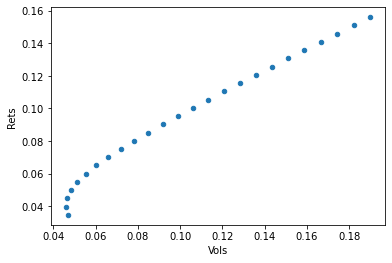

In [37]:
plot_frontier(25, rets_2, cov_2)

## test out the ret and vol at 10% target return

In [38]:
weights_2_10per = minimize_vol(0.10, rets_2, cov_2)
weights_2_10per

array([0.53628154, 0.        , 0.28541326, 0.17830521, 0.        ,
       0.        ])

In [39]:
portfolio_return(weights_2_10per, rets_2)

0.10000000011658378

In [40]:
portfolio_vol(weights_2_10per, cov_2)

0.10550984888916451